<a href="https://colab.research.google.com/github/llukitas/Interbank_Kaggle/blob/master/g_lucas_caso_creditov2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Instalacion de utilitarios Pyspark

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.3.4/spark-2.3.4-bin-hadoop2.7.tgz
!tar xf spark-2.3.4-bin-hadoop2.7.tgz

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz


In [0]:
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"


In [5]:
!pip install pyspark

     |████████████████████████████████| 215.7MB 55kB/s 
     |████████████████████████████████| 204kB 36.6MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.4-py2.py3-none-any.whl size=216130387 sha256=e440bc1f4bec3a9673e357f95e6398f5be8e57fca3181a206ecec29bbaa10a3e
  Stored in directory: /root/.cache/pip/wheels/ab/09/4d/0d184230058e654eb1b04467dbc1292f00eaa186544604b471
Successfully built pyspark


In [0]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
spark = SparkSession.builder.master("local").getOrCreate()
sc = SparkContext.getOrCreate()

# 1. Lectura del origen datos

In [0]:
# Lectura desde un archivo fisico
from google.colab import files
uploaded = files.upload()

In [7]:

# Conexion al drive
#---------------------------
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [8]:
ls

drive/        spark-2.3.4-bin-hadoop2.7/     spark-2.4.4-bin-hadoop2.7/
sample_data/  spark-2.3.4-bin-hadoop2.7.tgz  spark-2.4.4-bin-hadoop2.7.tgz


#2.  Cargando los datos en formato Spark

In [9]:
credito=spark.read.csv('/content/drive/My Drive/AGRARIA_ML/Training R ML en Casos de Negocios/2_caso negocio 2 riesgo crediticio/2_DS_creditos.csv',sep=',', header=True, inferSchema=True)
# 2.1 Revisión de formatos
credito.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Default: integer (nullable = true)
 |-- Prct_uso_tc: double (nullable = true)
 |-- Edad: integer (nullable = true)
 |-- Nro_prestao_retrasados: integer (nullable = true)
 |-- Prct_deuda_vs_ingresos: double (nullable = true)
 |-- Mto_ingreso_mensual: string (nullable = true)
 |-- Nro_prod_financieros_deuda: integer (nullable = true)
 |-- Nro_retraso_60dias: integer (nullable = true)
 |-- Nro_creditos_hipotecarios: integer (nullable = true)
 |-- Nro_retraso_ultm3anios: integer (nullable = true)
 |-- Nro_dependiente: string (nullable = true)



In [0]:
from pyspark.sql.types import DoubleType, IntegerType
credito = credito.withColumn("Mto_ingreso_mensual", credito["Mto_ingreso_mensual"].cast(DoubleType()))
credito = credito.withColumn("Nro_dependiente", credito["Nro_dependiente"].cast(DoubleType()))

In [11]:
credito.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Default: integer (nullable = true)
 |-- Prct_uso_tc: double (nullable = true)
 |-- Edad: integer (nullable = true)
 |-- Nro_prestao_retrasados: integer (nullable = true)
 |-- Prct_deuda_vs_ingresos: double (nullable = true)
 |-- Mto_ingreso_mensual: double (nullable = true)
 |-- Nro_prod_financieros_deuda: integer (nullable = true)
 |-- Nro_retraso_60dias: integer (nullable = true)
 |-- Nro_creditos_hipotecarios: integer (nullable = true)
 |-- Nro_retraso_ultm3anios: integer (nullable = true)
 |-- Nro_dependiente: double (nullable = true)



In [12]:
# Dimensiona de base
print((credito.count(),len(credito.columns)))

(150000, 12)


In [13]:
# 2.2 Exploracion inicial
credito.describe().show()

+-------+------------------+-------------------+------------------+------------------+----------------------+----------------------+-------------------+--------------------------+-------------------+-------------------------+----------------------+------------------+
|summary|                ID|            Default|       Prct_uso_tc|              Edad|Nro_prestao_retrasados|Prct_deuda_vs_ingresos|Mto_ingreso_mensual|Nro_prod_financieros_deuda| Nro_retraso_60dias|Nro_creditos_hipotecarios|Nro_retraso_ultm3anios|   Nro_dependiente|
+-------+------------------+-------------------+------------------+------------------+----------------------+----------------------+-------------------+--------------------------+-------------------+-------------------------+----------------------+------------------+
|  count|            150000|             150000|            150000|            150000|                150000|                150000|             120269|                    150000|             1500

In [14]:
# 2.3 Proceso para identificar valores nulos en cada variables
from pyspark.sql.functions import col,sum
credito.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in credito.columns)).show()
credito.select(*(sum(col(c).isNull().cast("int")/150000).alias(c) for c in credito.columns)).show()

+---+-------+-----------+----+----------------------+----------------------+-------------------+--------------------------+------------------+-------------------------+----------------------+---------------+
| ID|Default|Prct_uso_tc|Edad|Nro_prestao_retrasados|Prct_deuda_vs_ingresos|Mto_ingreso_mensual|Nro_prod_financieros_deuda|Nro_retraso_60dias|Nro_creditos_hipotecarios|Nro_retraso_ultm3anios|Nro_dependiente|
+---+-------+-----------+----+----------------------+----------------------+-------------------+--------------------------+------------------+-------------------------+----------------------+---------------+
|  0|      0|          0|   0|                     0|                     0|              29731|                         0|                 0|                        0|                     0|           3924|
+---+-------+-----------+----+----------------------+----------------------+-------------------+--------------------------+------------------+-------------------------+

#3.  Imputacion  de datos
Se identifico que hay 2 columnas con valores nulos o vacios:

Nro_dependiente   -->    2.6% nulos imputamos valores

 Mto_ingreso_mensual  -->      19.87% nulos imputamos valores

In [15]:
#2.4 Variable objetivo
print(credito.count())
credito.groupBy('Nro_dependiente').count().show(1000)

150000
+---------------+-----+
|Nro_dependiente|count|
+---------------+-----+
|            8.0|   24|
|            0.0|86902|
|            7.0|   51|
|           null| 3924|
|            1.0|26316|
|            4.0| 2862|
|            3.0| 9483|
|            2.0|19522|
|           10.0|    5|
|           13.0|    1|
|            6.0|  158|
|           20.0|    1|
|            5.0|  746|
|            9.0|    5|
+---------------+-----+



In [16]:
#credito.stat.approxQuantile("Nro_dependiente", Array(0.5), 0.25)
credito.approxQuantile("Mto_ingreso_mensual", [0.5], 0.25)

[5400.0]

In [17]:
# imputacion por mediana
from pyspark.ml.feature import Imputer 
credito.show (5)
imputer = Imputer (inputCols = ["Mto_ingreso_mensual", "Nro_dependiente"], outputCols = ["Mto_ingreso_mensual", "Nro_dependiente"]) 
model = imputer.setStrategy("median").fit (credito) 
credito = model.transform (credito) 
credito.show (5)


+---+-------+-----------+----+----------------------+----------------------+-------------------+--------------------------+------------------+-------------------------+----------------------+---------------+
| ID|Default|Prct_uso_tc|Edad|Nro_prestao_retrasados|Prct_deuda_vs_ingresos|Mto_ingreso_mensual|Nro_prod_financieros_deuda|Nro_retraso_60dias|Nro_creditos_hipotecarios|Nro_retraso_ultm3anios|Nro_dependiente|
+---+-------+-----------+----+----------------------+----------------------+-------------------+--------------------------+------------------+-------------------------+----------------------+---------------+
|  1|      1|0.766126609|  45|                     2|           0.802982129|             9120.0|                        13|                 0|                        6|                     0|            2.0|
|  2|      0|0.957151019|  40|                     0|           0.121876201|             2600.0|                         4|                 0|                        0|

In [18]:
#2.4 Variable objetivo
print(credito.count())
credito.groupBy('Default').count().show()
# Efectividad de venta
(10026/150000)*100

150000
+-------+------+
|Default| count|
+-------+------+
|      1| 10026|
|      0|139974|
+-------+------+



6.683999999999999

# Informacion Value

In [19]:
!pip install scorecardpy

     |████████████████████████████████| 61kB 1.9MB/s 
  Created wheel for scorecardpy: filename=scorecardpy-0.1.9.1.1-cp36-none-any.whl size=58169 sha256=e335a6f180aa0a39cfe6f8a67f8ade7c5d6e3c684502f99b6deeaa81313c2bb4
  Stored in directory: /root/.cache/pip/wheels/8f/4c/98/567ff70984acd88ffae211d8fc209e34b98fb43ff27f09fdd3
Successfully built scorecardpy


In [0]:
import scorecardpy as sc
import pandas as pd

In [21]:
type(credito)

pyspark.sql.dataframe.DataFrame

In [22]:
df = credito.toPandas()
type(df)

pandas.core.frame.DataFrame

In [0]:
df.drop(['ID'], axis='columns', inplace=True)

In [24]:
df.head()

,Default,Prct_uso_tc,Edad,Nro_prestao_retrasados,Prct_deuda_vs_ingresos,Mto_ingreso_mensual,Nro_prod_financieros_deuda,Nro_retraso_60dias,Nro_creditos_hipotecarios,Nro_retraso_ultm3anios,Nro_dependiente
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [25]:
# Formato de variables ScorecardPy
dt_s = sc.var_filter(df, y="Default")

[INFO] filtering variables ...
Variable filtering on 150000 rows and 11 columns in 00:04:17 
0 variables are removed


In [26]:
bins = sc.woebin(dt_s, y="Default")

[INFO] creating woe binning ...
Binning on 150000 rows and 11 columns in 00:00:12


In [27]:
# De acuerdo al analisis de correlacion de Spearman o Information Value
# Las variables m;as relevantes son: Nro_retraso_60dias, Mto_ingreso_mensual, Nro_prestao_retrasados
sc.iv(dt_s, y="Default")

,variable,info_value
4,Nro_retraso_60dias,0.881208
9,Mto_ingreso_mensual,0.836594
1,Nro_prestao_retrasados,0.761158
5,Nro_retraso_ultm3anios,0.601024
2,Prct_deuda_vs_ingresos,0.406449
3,Prct_uso_tc,0.307700
8,Edad,0.274367
0,Nro_prod_financieros_deuda,0.116379
7,Nro_creditos_hipotecarios,0.068348
6,Nro_dependiente,0.035484


{'Edad': <Figure size 432x288 with 2 Axes>,
 'Mto_ingreso_mensual': <Figure size 432x288 with 2 Axes>,
 'Nro_creditos_hipotecarios': <Figure size 432x288 with 2 Axes>,
 'Nro_dependiente': <Figure size 432x288 with 2 Axes>,
 'Nro_prestao_retrasados': <Figure size 432x288 with 2 Axes>,
 'Nro_prod_financieros_deuda': <Figure size 432x288 with 2 Axes>,
 'Nro_retraso_60dias': <Figure size 432x288 with 2 Axes>,
 'Nro_retraso_ultm3anios': <Figure size 432x288 with 2 Axes>,
 'Prct_deuda_vs_ingresos': <Figure size 432x288 with 2 Axes>,
 'Prct_uso_tc': <Figure size 432x288 with 2 Axes>}

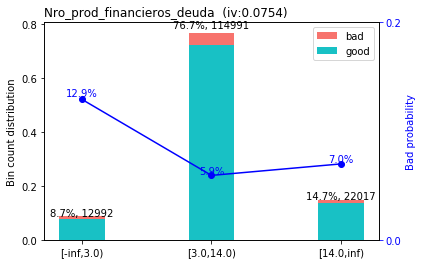

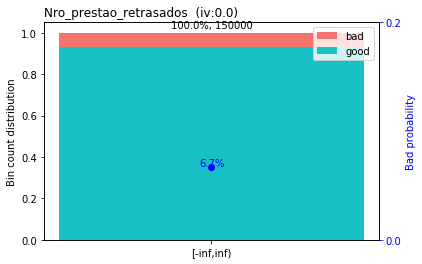

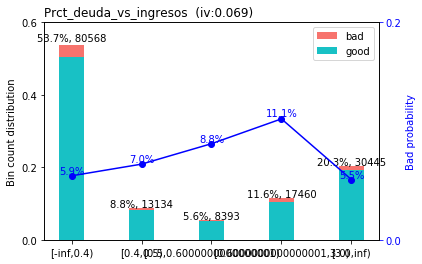

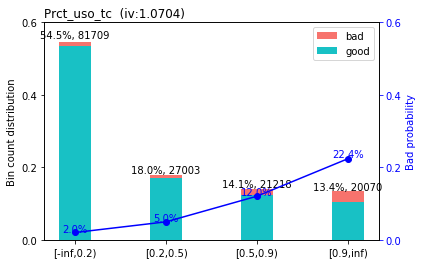

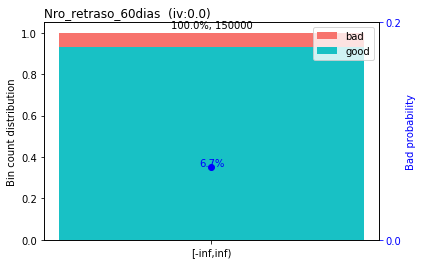

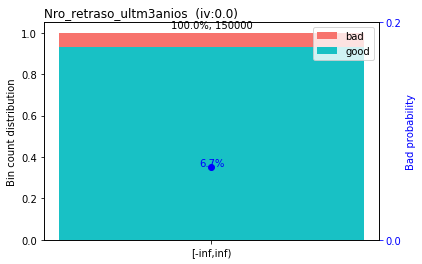

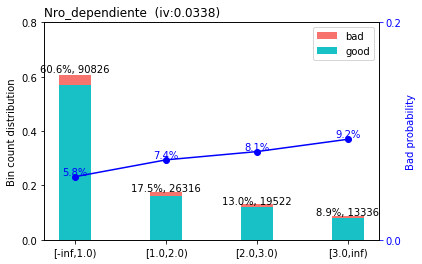

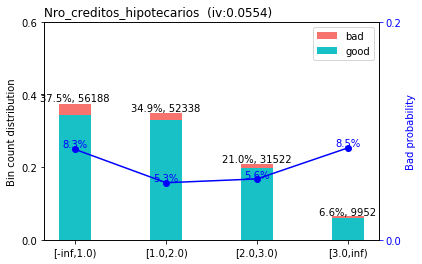

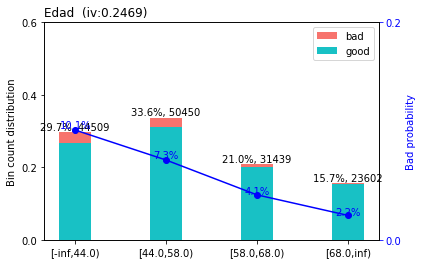

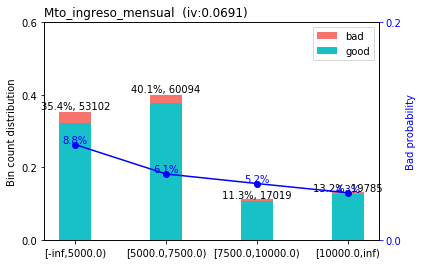

In [28]:
# graficando los Insight identificados
#bins = sc.woebin(dt_s[['Nro_retraso_60dias','Mto_ingreso_mensual','Nro_prestao_retrasados','Nro_retraso_ultm3anios','Prct_deuda_vs_ingresos']], y="Default")
sc.woebin_plot(bins)

#3.  Preparando la información para el modelamiento

In [0]:
# REdefiniendo feature
# Se elimina en caso ya exista una nueva columna
credito=credito.drop("features")

In [0]:
# Creando las variables nevesarias para el modelamiento
# ESCENARIO 1 -- NO USADO
# Consolidacion de variables
from pyspark.ml.feature import StringIndexer 
from pyspark.ml.feature import VectorAssembler  
# Transformacion
df_assembler = VectorAssembler(inputCols=['Nro_retraso_60dias','Mto_ingreso_mensual','Nro_prestao_retrasados','Nro_retraso_ultm3anios'], outputCol="features")
credito = df_assembler.transform(credito)

In [46]:
#Revision
#DS_Renovacion_prest.printSchema()
credito_t.select('Default','features').show(3,False)

+-------+--------------------------------+
|Default|features                        |
+-------+--------------------------------+
|1      |[0.0,9120.0,2.0,0.0,0.802982129]|
|0      |(5,[1,4],[2600.0,0.121876201])  |
|0      |[1.0,3042.0,1.0,0.0,0.085113375]|
+-------+--------------------------------+
only showing top 3 rows



In [0]:
#Matriz de Modelamiento
model_df_credito_t=credito_t.select('Default','features')

In [48]:
model_df_credito_t.printSchema()

root
 |-- Default: integer (nullable = true)
 |-- features: vector (nullable = true)



# 5.  Seleccionando la muestra de aprendizaje y validacion


In [58]:
# Definicion de muestra de entrenamiento y Validacion

training_df,test_df=model_df_credito_t.randomSplit([0.5,0.5],seed=1234) 

# Tamaño de muestra
print(training_df.count(),test_df.count())

75059 74941


#6.  Modelamiento de predictivo

In [0]:
# Modelamiento de Regresion Logistica

from pyspark.ml.classification import LogisticRegression
log_reg=LogisticRegression(maxIter=10,labelCol='Default').fit(training_df)

In [0]:
# Modelamiento de Regresion Logistica

from pyspark.ml.classification import LogisticRegression

log_reg=LogisticRegression(labelCol='Default').fit(training_df)

In [68]:
# Revision
log_reg.coefficients

DenseVector([0.5107, -0.0, 0.527, -1.0027, -0.0])

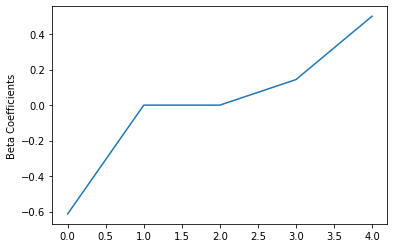

In [61]:
# Representacion grafica de los betas de la REgresion Logistica
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(log_reg.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

In [70]:
# Aplicando sobre la data Train el modelo identificado

train_results=log_reg.evaluate(training_df).predictions

# Verificando las probabilidad en los clientes con compra

train_results.filter(train_results['Default']==1).select(['Default','prediction','probability']).show(10,False)

+-------+----------+----------------------------------------+
|Default|prediction|probability                             |
+-------+----------+----------------------------------------+
|1      |0.0       |[0.9314516537270227,0.06854834627297728]|
|1      |0.0       |[0.8907535708418821,0.10924642915811783]|
|1      |0.0       |[0.8934885438315172,0.10651145616848275]|
|1      |0.0       |[0.8945670454913642,0.10543295450863577]|
|1      |0.0       |[0.8971881964828461,0.10281180351715391]|
|1      |0.0       |[0.8994387080807463,0.10056129191925357]|
|1      |0.0       |[0.9008091841941686,0.09919081580583132]|
|1      |0.0       |[0.9018428472316968,0.09815715276830322]|
|1      |0.0       |[0.9021946289896655,0.09780537101033443]|
|1      |0.0       |[0.9035940045792964,0.09640599542070354]|
+-------+----------+----------------------------------------+
only showing top 10 rows



In [62]:
# Aplicando sobre la data Train el modelo identificado
train_results=log_reg.evaluate(training_df).predictions
# Verificando las probabilidad en los clientes con compra
train_results.filter(train_results['Default']==1).select(['Default','prediction','probability']).show(10,False)

+-------+----------+----------------------------------------+
|Default|prediction|probability                             |
+-------+----------+----------------------------------------+
|1      |0.0       |[0.8986978929295146,0.10130210707048538]|
|1      |0.0       |[0.8848377355173312,0.11516226448266886]|
|1      |0.0       |[0.8927471888345943,0.10725281116540569]|
|1      |0.0       |[0.895779040867928,0.10422095913207202] |
|1      |0.0       |[0.9029408180736285,0.09705918192637147]|
|1      |0.0       |[0.9088552858008914,0.09114471419910868]|
|1      |0.0       |[0.9123505302793428,0.08764946972065726]|
|1      |0.0       |[0.9149334371278623,0.08506656287213762]|
|1      |0.0       |[0.9158020073293284,0.08419799267067173]|
|1      |0.0       |[0.919204591222257,0.08079540877774308] |
+-------+----------+----------------------------------------+
only showing top 10 rows



# 7. Evaluacion del modelo


In [0]:
# Aplicando el modelo predictivo
transformed = log_reg.transform(test_df)

In [72]:
test_df.show(5)

+-------+---------+
|Default| features|
+-------+---------+
|      0|(5,[],[])|
|      0|(5,[],[])|
|      0|(5,[],[])|
|      0|(5,[],[])|
|      0|(5,[],[])|
+-------+---------+
only showing top 5 rows



In [73]:
# Revision
transformed.show(3,False)

+-------+---------+----------------------------------------+----------------------------------------+----------+
|Default|features |rawPrediction                           |probability                             |prediction|
+-------+---------+----------------------------------------+----------------------------------------+----------+
|0      |(5,[],[])|[2.6092050058410545,-2.6092050058410545]|[0.9314516537270227,0.06854834627297728]|0.0       |
|0      |(5,[],[])|[2.6092050058410545,-2.6092050058410545]|[0.9314516537270227,0.06854834627297728]|0.0       |
|0      |(5,[],[])|[2.6092050058410545,-2.6092050058410545]|[0.9314516537270227,0.06854834627297728]|0.0       |
+-------+---------+----------------------------------------+----------------------------------------+----------+
only showing top 3 rows



In [74]:
# LLamando a las librerias de evaluacion de modelamiento

from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
results = transformed.select(['probability', 'Default'])
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)
 
metrics = metric(scoreAndLabels)
print("The ROC score is (@numTrees=200): ", metrics.areaUnderROC)

AttributeError: ignored

In [0]:
import matplotlib.pyplot as plt
import numpy as np

trainingSummary = log_reg.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))